In [38]:
!pip install mido


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Pilotes\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [39]:
#%% librerías y constantes necesarias
import numpy as np         
import sounddevice as sd       
import matplotlib.pyplot as plt
from tkinter import *

SRATE, CHUNK = 48000, 1024

In [40]:
%%writefile osc.py

from consts import *
import numpy as np         
import sounddevice as sd       
import matplotlib.pyplot as plt

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out

Overwriting osc.py


In [41]:
%%writefile oscFM.py

import numpy as np   
from osc import *
import matplotlib.pyplot as plt
from consts import *

class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0

        # moduladora = βsin(2πfm)
        self.mod = Osc(freq=fm,amp=beta)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = self.mod.next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 

    def setBeta(self,beta):
        self.beta = beta
        self.mod.amp = beta

    def setFm(self,fm):
        self.fm = fm
        self.mod.freq = fm

    def getBeta(self):
        return self.beta    

    def getFm(self):
        return self.fm

        

Overwriting oscFM.py


In [42]:
%%writefile env.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *

# Lo mas común es utilizar tiempos en el eje X para definir envolventes
# método para convertir tiempo a frames
def timeToFrame(t): return round(t*SRATE)

class Env:
    # points = [(t0,v0),(t1,v1),(t2,v2),...] valores de la envolvente en instantes de tiempo
    def __init__(self,points,xAxis='samples'):
        if points[0][0]!=0: # el primer tiempo tiene que ser 0
                            # podríamos autocompletar con (0,0) pero mejor dar error
            raise Exception(f'Bad defined env: initial point {points[0]}')

        # si los valores de x están en tiempo traducimos samples
        if xAxis=='time': # si está en frames en vez de tiempo convertimos a tiempos
            points = [(timeToFrame(x),y) for (x,y) in points]

        # construimos la envolvente generando segmentos entre los puntos dados
        self.env = np.zeros(0)        
        (x0,y0) = points[0]  # punto inicial
        for (x,y) in points[1:]:
            self.env = np.concatenate((
                self.env, 
                np.linspace(y0,y,x-x0+1)[:-1] # generamos x-x0+1 puntos y luego descartamos el último 
                ))                            # que vuelve a generarse en el siguiente segmento
                                              # así evitamos "meseta" entre 2 puntos  
            (x0,y0) = (x,y) # nuevo punto de origen
        

        # una vez generada la envolvente, la extendemos hasta completar el último chunk
        # con el último valor self.last: mantiene ese valor hasta el final del chunk
        # Así la longitud de la envolvente es un múltiplo de CHUNK
        # (Esto evita evita errores al multiplicar arrays en numpy)        
        restFrames = CHUNK - (points[-1][0]-points[0][0]) % CHUNK  
        self.env = np.concatenate((self.env, np.full(restFrames,points[-1][1])))        
        #restFrames = CHUNK - (points[-1][0]-points[0][0]) % CHUNK  
        #self.env = np.concatenate((self.env, np.full(restFrames,self.last)))        

        # frame actual 
        self.frame = 0
        
        # la envolvente se extiende indefinidamente con el ultimo valor 
        # no hace falta devolver chunks con ese valor por la sobrecarga del 
        # operador * en numpy: escalar*array o array*array
        self.last = self.env[-1]

    # método next del generador de señal: devuelve array de tamaño CHUNK o valor cte
    def next(self):
        # devolvemos chuncks mientras queda envolvente
        if self.frame<self.env.shape[0]:
            out = self.env[self.frame:self.frame+CHUNK]
            self.frame += CHUNK
            return out
        else: # y la última muestra cuando no quedan
            return np.array([self.last])

    # reseteo del frame en cualquier momento
    # será util después cuando esté sonando una nota y vuelva a lanzarse:
    # se para la envolvente actual y se reinicia
    def reset(self):
        self.frame = 0        

Overwriting env.py


In [43]:
%%writefile consts.py

# para todo el proyecto (no cambian)
SRATE = 48000 # frecuencia de muestreo
CHUNK = 1024  # tamaño de los CHUNKs

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]


Overwriting consts.py


In [44]:
%%writefile slider.py

import numpy as np    
import matplotlib.pyplot as plt
from tkinter import *

class Slider:
    def __init__(self,tk,name='a',ini=0.2,from_=0.0,to=1.0,step=0.1,orient=HORIZONTAL,packSide=TOP):
        self.val = DoubleVar() # para guardar y modificar el valor del parámetro en cuestión
        self.val.set(ini)
                
        self.scale = Scale(tk, label=name,
            from_=from_, to=to, resolution=step, 
            orient=orient, width=30,sliderlength=10, length=300, bd=6,
            variable = self.val)
            
        self.scale.pack(side=packSide)

    def get(self):
        return self.val.get()

Overwriting slider.py


In [45]:
%%writefile adsr.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from env import *

class ADSR:
    def __init__(self,att,dec,sus,rel):
        self.act = Env([(0,0),(att,1),(att+dec,sus)],xAxis='time')
        self.sus = sus
        self.rel = Env([(0,sus),(rel,0)],xAxis='time')
        self.state = 'off' # act, rel
        self.last = 0

    def next(self):
        if self.state=='off': 
            self.last = 0
            return 0
        elif self.state=='act':             
            out = self.act.next()            
            self.last = out[-1]
            return out
        elif self.state=='rel': 
            out = self.rel.next()   
            self.last = out[-1]
            # cuando se acaba el release pasa a estado off           
            if self.last==0:
                self.state = 'off'            
            return out

    def start(self):
        self.state='act'    
        self.act.reset()

    def release(self):        
        self.rel.reset()
        self.state='rel'    


Overwriting adsr.py


In [46]:
%%writefile synthFM.py

import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from tkinter import *
from adsr import *
from oscFM import *

class SynthFM:
    def __init__(self,
                fc=110,amp=1.0,ratio=0.5, beta=5.0,   # parámetros del generador FM
                attack=0.01,decay=0.02, sustain=0.3,release=1.0): # parámetros del ADSR        
        self.fc = fc
        self.amp =  amp
        self.ratio = ratio
        self.fm = self.ratio*self.fc # fm en función de fc y ratio
        self.beta = beta
        
        self.signal = OscFM(self.fc,amp=self.amp,fm=self.fm,beta=self.beta) # generador
        self.adsr = ADSR(attack,decay,sustain,release)  # envolvente adsr

        # se dispara automáticamente
        self.state = 'on' # activo
        self.adsr.start() # adsr activa

    def start(self):
        self.adsr.start()

    # siguiente chunk del generador
    def next(self): 
        out = self.signal.next()*self.adsr.next()
        if self.adsr.state=='off': # cuando acaba el adsr por completo (incluido el release)
            self.state = 'off'     # el sinte tb acaba de producir señal
        return out     
    
    # el noteOff del sinte activa el release del ADSR
    def noteOff(self):
        #print('release')
        self.adsr.release()

    def setAmp(self,val): 
        self.amp = val 

    def setFm(self,val): 
        self.fm = val  

    def setBeta(self,val): 
        self.beta = val


Overwriting synthFM.py


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from consts import *
from tkinter import *
from slider import *
from adsr import *
from synthFM import *

class Instrument:
    def __init__(self, tk, name="FM synthetizer", amp=0.2, ratio=3, beta=0.6): 
        frame = LabelFrame(tk, text=name, bg="#808090")
        frame.pack(side=LEFT)
        # Synth params con sus sliders
        frameOsc = LabelFrame(frame, text="FM oscillator", bg="#808090")
        frameOsc.pack(side=LEFT, fill="both", expand="yes")
        
        self.ampS = Slider(frameOsc, 'amp', packSide=TOP, ini=amp, from_=0.0, to=1.0, step=0.05) 
        self.ratioS = Slider(frameOsc, 'ratio', packSide=TOP, ini=ratio, from_=0.0, to=20.0, step=0.5)
        self.betaS = Slider(frameOsc, 'beta', packSide=TOP, ini=beta, from_=0.0, to=10.0, step=0.05) 
        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(frameOsc, height=4, width=40)
        text.pack(side=BOTTOM)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up)

        # ADSR params con sus sliders
        frameADSR = LabelFrame(frame, text="ADSR", bg="#808090")
        frameADSR.pack(side=LEFT, fill="both", expand="yes")
        self.attackS = Slider(frameADSR, 'attack', ini=0.01, from_=0.0, to=0.5, step=0.005, orient=HORIZONTAL, packSide=TOP) 
        self.decayS = Slider(frameADSR, 'decay', ini=0.01, from_=0.0, to=0.5, step=0.005, orient=HORIZONTAL, packSide=TOP)
        self.sustainS = Slider(frameADSR, 'sustain', ini=0.4, from_=0.0, to=1.0, step=0.01, orient=HORIZONTAL, packSide=TOP) 
        self.releaseS = Slider(frameADSR, 'release', ini=0.5, from_=0.0, to=4.0, step=0.05, orient=HORIZONTAL, packSide=TOP) 

        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()

    # obtenemos todos los parámetros del sinte (puede servir para crear presets)
    def getConfig(self):
        return (self.ampS.get(), self.ratioS.get(), self.betaS.get(),
                self.attackS.get(), self.decayS.get(), self.sustainS.get(),
                self.releaseS.get())

    # activación de nota
    def noteOn(self, midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].adsr.last # ultimo valor de la envolvente: inicio del fadeOut
            env = Env([(0, lastAmp), (CHUNK, 0)]).next()   # envolvente             
            signal = self.channels[midiNote].next()     # señal          
            self.tails[midiNote] = env * signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        freq = freqsMidi[midiNote]
        self.channels[midiNote] = SynthFM(
                fc=freq,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack=self.attackS.get(), decay=self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())

    # apagar nota -> propagamos noteOff al synth, que se encargará de hacer el release
    def noteOff(self, midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].noteOff()

    # lectura de teclas de teclado como eventos tkinter
    def down(self, event):
        c = event.keysym

        # tecla "panic" -> apagamos todos los sintes de golpe!
        if c == '0': 
            self.stop()            
        elif c in teclas:
            midiNote = 48 + teclas.index(c) # buscamos indice y trasnportamos a C3 (48 en midi)        
            print(f'noteOn {midiNote}')
            self.noteOn(midiNote)         # arrancamos noteOn con el instrumento 
            
    def up(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = 48 + teclas.index(c) # buscamos indice y hacemos el noteOff
            print(f'noteOff {midiNote}')
            self.noteOff(midiNote)

    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            if self.channels[c].state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        return out        

    # boton del pánico
    def stop(self):
        self.channels = dict() # delegamos en el garbage collector

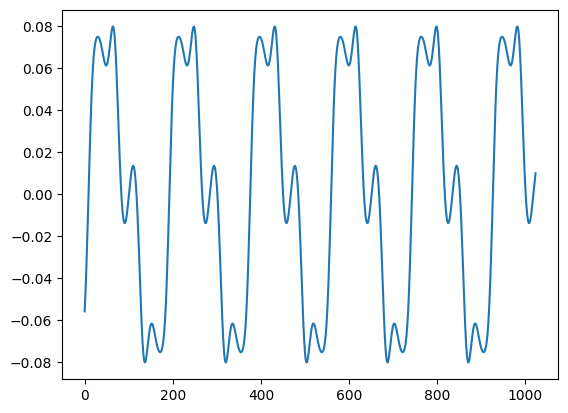

In [56]:
from instrument import *
import sounddevice as sd
import matplotlib.pyplot as plt
from tkinter import *

tk = Tk()
ins = Instrument(tk)
ins.amp = 1
ins.sustain=0.8

ins.noteOn(60)
signal = np.zeros(0)
for i in range(25):
    signal = np.concatenate((signal,ins.next()))

N = 1024
s = signal[-N:]

ins.noteOn(70)
signal2 = np.zeros(0)
for i in range(25):
    signal2 = np.concatenate((signal2,ins.next()))

#s = np.concatenate((s,signal2[:N]))

tot = np.concatenate((signal,signal2))
sd.play(tot)
sd.wait()

plt.plot(s)    



In [ ]:
import sys
!{sys.executable} -m pip install mido

import mido

class MidiSequencer:
    def __init__(self):
        self.instruments = {}

    def add_instrument(self, channel, instrument):
        self.instruments[channel] = instrument

    def play_midi_file(self, file_path):
        mid = mido.MidiFile(file_path)
        for msg in mid.play():
            if msg.type == 'note_on':
                channel = msg.channel
                if channel in self.instruments:
                    self.instruments[channel].noteOn(msg.note)
            elif msg.type == 'note_off':
                channel = msg.channel
                if channel in self.instruments:
                    self.instruments[channel].noteOff(msg.note)

# Crear instancias de instrumentos con distintos timbres
piano = Instrument(tk, 'Piano', amp=0.2, ratio=3, beta=0.6)
violin = Instrument(tk, 'Violin', amp=0.3, ratio=2, beta=0.5)
cello = Instrument(tk, 'Cello', amp=0.4, ratio=2.5, beta=0.5)  # Chelo
guitar = Instrument(tk, 'Guitar', amp=0.3, ratio=2, beta=0.4)  # Guitarra
trombone = Instrument(tk, 'Trombone', amp=0.5, ratio=3, beta=0.7)  # Trombón

# Crear el secuenciador MIDI y agregar los instrumentos a distintos canales
sequencer = MidiSequencer()
sequencer.add_instrument(0, piano)    # Canal 0 para el piano
sequencer.add_instrument(1, violin)    # Canal 1 para el violín
sequencer.add_instrument(2, cello)     # Canal 2 para el chelo
sequencer.add_instrument(3, guitar)    # Canal 3 para la guitarra
sequencer.add_instrument(4, trombone)   # Canal 4 para el trombón

# Reproducir un archivo MIDI
sequencer.play_midi_file('pirates.mid')

KeyboardInterrupt: 